# **Initialisation**

In [ ]:
from tensorflow import keras
import tensorflow as tf
from keras.datasets import mnist
from keras.datasets import cifar100
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
from keras.callbacks import CSVLogger
import random
import cv2
from sklearn.utils import shuffle
import skimage.measure

In [ ]:
!pip install pyyaml h5py

In [ ]:
(trainx, trainy), (testx, testy) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


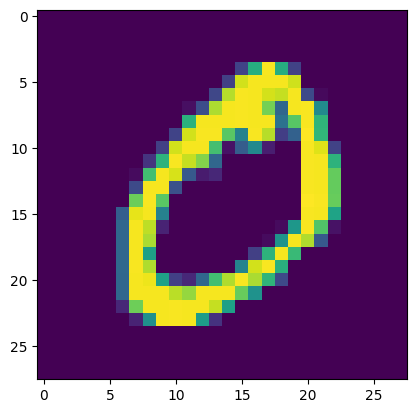

In [ ]:
plt.imshow(trainx[1])

In [ ]:
trainy[1]

0

# **Large CNNs**

## Model

In [ ]:
trainxmm = trainx/255.0
testxmm = testx/255.0

In [ ]:
# trainxmm = np.expand_dims(trainxmm, axis=3)
# testxmm = np.expand_dims(trainxmm, axis=3)

In [ ]:
# trainxmm.shape

**Wider layer**

In [ ]:
def metric(y_true,y_pred):
  # print(type(y_true))
  result = y_pred * tf.transpose(y_true)
  return tf.reduce_sum(result)/2*tf.shape(result)

In [ ]:
model = keras.Sequential([
    # keras.layers.MaxPooling2D((2,2),input_shape = (28,28,1)),
    # keras.layers.MaxPooling2D((2,2)),
    keras.layers.RandomRotation(0.5,input_shape = (14,14,1)),

    keras.layers.Conv2D(filters = 16, padding = 'same', kernel_size = (3,3), activation = 'relu'),

    # keras.layers.Conv2D(filters = 32, padding = 'same', kernel_size = (3,3), activation = 'relu'),
    # keras.layers.Conv2D(filters = 64, padding = 'same', kernel_size = (3,3), activation = 'relu'),
    # keras.layers.MaxPooling2D((2,2)),
    # keras.layers.Conv2D(filters = 128, padding = 'same', kernel_size = (3,3), activation = 'relu'),
    keras.layers.Conv2D(filters = 256, padding = 'same', kernel_size = (3,3), activation = 'relu'),

    keras.layers.Flatten(),
    keras.layers.Dense(1000, activation = 'relu'),
    # keras.layers.Dense(11, activation = 'relu'),
    # keras.layers.Dropout(0.05),
    keras.layers.Dense(11, activation = 'sigmoid')
])

model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = [keras.metrics.CategoricalAccuracy()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation (RandomRot  (None, 14, 14, 1)         0         
 ation)                                                          
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 256)       37120     
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 1000)              50177000  
                                                                 
 dense_1 (Dense)             (None, 11)                11011     
                                                        

In [ ]:
def add_f_train(trainy,n):
  trainy_new = np.zeros((trainy.shape[0],n+1))
  for i in range(trainy.shape[0]):
    trainy_new[i,trainy[i] + 1] = 1
    trainy_new[i,0] = 0

  return trainy_new

In [ ]:
def add_non_numbers(x, y):
  trainx_new = np.zeros((x.shape[0]*11//10, x.shape[1], x.shape[2]))
  trainy_new = np.zeros((y.shape[0]*11//10, y.shape[1]))

  trainx_new [:x.shape[0]] = x
  for i in range(x.shape[0]//10):
    trainx_new [x.shape[0]+i] = np.random.rand(x.shape[1],x.shape[2])/random.randint(1,100)

  trainy_new [:y.shape[0]] = y
  trainy_new [y.shape[0]:,0] = np.ones(y.shape[0]*1//10)

  return shuffle(trainx_new, trainy_new)

In [ ]:
def add_lines(x):
  a = random.randint(1,4)
  if a == 1:
    cv2.line(x,
          (0,random.randint(0,X.shape[1]-1)),
          (X.shape[2]-1,random.randint(0,X.shape[1]-1)),
          (1,1,1),
          random.randint(2,2))/255

  elif a == 2:
    cv2.line(x,
          (random.randint(0,X.shape[2]-1),0),
          (random.randint(0,X.shape[2]-1),X.shape[1]-1),
          (1,1,1),
          random.randint(2,2))/255

  elif a == 3:
    cv2.line(x,
          (0,random.randint(0,X.shape[1]-1)),
          (random.randint(0,X.shape[2]-1),X.shape[1]-1),
          (1,1,1),
          random.randint(2,2))/255

  else:
    cv2.line(x,
          (random.randint(0,X.shape[2]-1),0),
          (X.shape[2]-1, random.randint(0,X.shape[1]-1)),
          (1,1,1),
          random.randint(2,2))/255

In [ ]:
def reduce(xmm,n=2):
  x = np.zeros((xmm.shape[0], xmm.shape[1]//n, xmm.shape[2]//n))
  for i in range(xmm.shape[0]):
    x[i] = skimage.measure.block_reduce(xmm[i], (n,n), np.max)

  return x

In [ ]:
trainy_new = add_f_train(trainy,10)
testy_new = add_f_train(testy,10)

In [ ]:
trainy_new[1]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
xmm = reduce(trainxmm, n=2)
xmm_val = reduce(testxmm, n=2)

In [ ]:
X,y = add_non_numbers(xmm, trainy_new)

In [ ]:
for i in range((X.shape[0])//2):
  add_lines(X[i])

In [ ]:
X,y = shuffle(X,y)

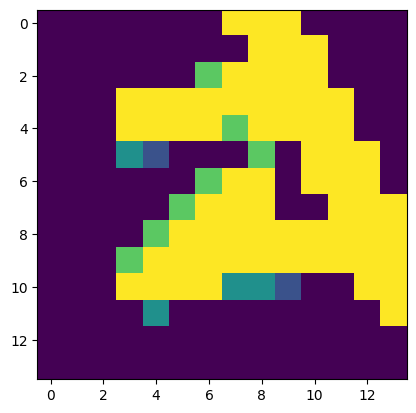

In [ ]:
plt.imshow(X[242])

In [ ]:
y[234]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Training

In [ ]:
from tqdm import tqdm

checkpoint_path = "training_1/val_loss.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

csv_logger = CSVLogger('training_log.csv', append=True)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor = 'val_loss',
                                                 verbose=1)

# Train the model with the new callback
for i in tqdm(range(100)):


  X,y = add_non_numbers(xmm, trainy_new)

  for i in range((X.shape[0])//2):
    add_lines(X[i])

  X,y = shuffle(X,y)


  X_val,y_val = add_non_numbers(xmm_val, testy_new)

  for i in range((X_val.shape[0])//2):
    add_lines(X_val[i])

  X_val,y_val = shuffle(X_val,y_val)


  model.fit(X,
    y,
    epochs=1,
    batch_size = 1000,
    validation_data=(X_val, y_val),
    callbacks=[csv_logger])

  0%|          | 0/100 [00:00<?, ?it/s]

66/66 [==============================] - 14s 105ms/step - loss: 0.0824 - categorical_accuracy: 0.2168 - val_loss: 0.0746 - val_categorical_accuracy: 0.2670


  1%|          | 1/100 [00:15<25:20, 15.36s/it]

66/66 [==============================] - 7s 105ms/step - loss: 0.0718 - categorical_accuracy: 0.2750 - val_loss: 0.0702 - val_categorical_accuracy: 0.2795


  2%|▏         | 2/100 [00:23<17:42, 10.84s/it]

66/66 [==============================] - 7s 105ms/step - loss: 0.0652 - categorical_accuracy: 0.3774 - val_loss: 0.0517 - val_categorical_accuracy: 0.5472


  3%|▎         | 3/100 [00:30<15:10,  9.39s/it]

66/66 [==============================] - 7s 105ms/step - loss: 0.0364 - categorical_accuracy: 0.7255 - val_loss: 0.0281 - val_categorical_accuracy: 0.7979


  4%|▍         | 4/100 [00:38<14:09,  8.85s/it]

66/66 [==============================] - 7s 105ms/step - loss: 0.0264 - categorical_accuracy: 0.8080 - val_loss: 0.0220 - val_categorical_accuracy: 0.8450


  5%|▌         | 5/100 [00:46<13:23,  8.46s/it]

66/66 [==============================] - 7s 105ms/step - loss: 0.0229 - categorical_accuracy: 0.8354 - val_loss: 0.0204 - val_categorical_accuracy: 0.8549


  6%|▌         | 6/100 [00:54<12:51,  8.21s/it]

66/66 [==============================] - 7s 107ms/step - loss: 0.0203 - categorical_accuracy: 0.8552 - val_loss: 0.0181 - val_categorical_accuracy: 0.8713


  7%|▋         | 7/100 [01:05<14:10,  9.15s/it]

66/66 [==============================] - 7s 107ms/step - loss: 0.0187 - categorical_accuracy: 0.8670 - val_loss: 0.0168 - val_categorical_accuracy: 0.8808


  8%|▊         | 8/100 [01:13<13:25,  8.75s/it]

66/66 [==============================] - 7s 112ms/step - loss: 0.0176 - categorical_accuracy: 0.8746 - val_loss: 0.0162 - val_categorical_accuracy: 0.8845


  9%|▉         | 9/100 [01:24<14:20,  9.46s/it]

66/66 [==============================] - 7s 109ms/step - loss: 0.0162 - categorical_accuracy: 0.8859 - val_loss: 0.0153 - val_categorical_accuracy: 0.8919


 10%|█         | 10/100 [01:35<15:13, 10.15s/it]

66/66 [==============================] - 7s 109ms/step - loss: 0.0154 - categorical_accuracy: 0.8930 - val_loss: 0.0141 - val_categorical_accuracy: 0.9025


 11%|█         | 11/100 [01:46<15:26, 10.41s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0147 - categorical_accuracy: 0.8974 - val_loss: 0.0133 - val_categorical_accuracy: 0.9075


 12%|█▏        | 12/100 [01:55<14:23,  9.81s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0141 - categorical_accuracy: 0.9034 - val_loss: 0.0133 - val_categorical_accuracy: 0.9078


 13%|█▎        | 13/100 [02:06<14:51, 10.24s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0135 - categorical_accuracy: 0.9059 - val_loss: 0.0127 - val_categorical_accuracy: 0.9105


 14%|█▍        | 14/100 [02:15<13:54,  9.71s/it]

66/66 [==============================] - 8s 117ms/step - loss: 0.0132 - categorical_accuracy: 0.9089 - val_loss: 0.0132 - val_categorical_accuracy: 0.9101


 15%|█▌        | 15/100 [02:23<13:13,  9.34s/it]

66/66 [==============================] - 7s 112ms/step - loss: 0.0128 - categorical_accuracy: 0.9121 - val_loss: 0.0125 - val_categorical_accuracy: 0.9132


 16%|█▌        | 16/100 [02:31<12:34,  8.98s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0124 - categorical_accuracy: 0.9147 - val_loss: 0.0120 - val_categorical_accuracy: 0.9164


 17%|█▋        | 17/100 [02:39<12:03,  8.72s/it]

66/66 [==============================] - 8s 116ms/step - loss: 0.0121 - categorical_accuracy: 0.9162 - val_loss: 0.0118 - val_categorical_accuracy: 0.9190


 18%|█▊        | 18/100 [02:48<11:47,  8.63s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0119 - categorical_accuracy: 0.9169 - val_loss: 0.0108 - val_categorical_accuracy: 0.9269


 19%|█▉        | 19/100 [02:59<12:36,  9.34s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0116 - categorical_accuracy: 0.9199 - val_loss: 0.0110 - val_categorical_accuracy: 0.9255


 20%|██        | 20/100 [03:10<13:06,  9.83s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0112 - categorical_accuracy: 0.9241 - val_loss: 0.0112 - val_categorical_accuracy: 0.9227


 21%|██        | 21/100 [03:18<12:22,  9.40s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0110 - categorical_accuracy: 0.9248 - val_loss: 0.0105 - val_categorical_accuracy: 0.9301


 22%|██▏       | 22/100 [03:29<12:55,  9.95s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0108 - categorical_accuracy: 0.9258 - val_loss: 0.0107 - val_categorical_accuracy: 0.9284


 23%|██▎       | 23/100 [03:41<13:17, 10.36s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0106 - categorical_accuracy: 0.9277 - val_loss: 0.0103 - val_categorical_accuracy: 0.9307


 24%|██▍       | 24/100 [03:52<13:29, 10.66s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0105 - categorical_accuracy: 0.9281 - val_loss: 0.0099 - val_categorical_accuracy: 0.9333


 25%|██▌       | 25/100 [04:01<12:31, 10.02s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0104 - categorical_accuracy: 0.9285 - val_loss: 0.0100 - val_categorical_accuracy: 0.9297


 26%|██▌       | 26/100 [04:09<11:39,  9.46s/it]

66/66 [==============================] - 8s 116ms/step - loss: 0.0102 - categorical_accuracy: 0.9303 - val_loss: 0.0092 - val_categorical_accuracy: 0.9385


 27%|██▋       | 27/100 [04:17<11:06,  9.13s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0099 - categorical_accuracy: 0.9318 - val_loss: 0.0092 - val_categorical_accuracy: 0.9359


 28%|██▊       | 28/100 [04:25<10:38,  8.86s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0099 - categorical_accuracy: 0.9331 - val_loss: 0.0091 - val_categorical_accuracy: 0.9389


 29%|██▉       | 29/100 [04:33<10:11,  8.62s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0097 - categorical_accuracy: 0.9343 - val_loss: 0.0094 - val_categorical_accuracy: 0.9348


 30%|███       | 30/100 [04:44<10:54,  9.34s/it]

66/66 [==============================] - 8s 114ms/step - loss: 0.0097 - categorical_accuracy: 0.9337 - val_loss: 0.0097 - val_categorical_accuracy: 0.9340


 31%|███       | 31/100 [04:55<11:19,  9.85s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0096 - categorical_accuracy: 0.9341 - val_loss: 0.0086 - val_categorical_accuracy: 0.9406


 32%|███▏      | 32/100 [05:04<10:34,  9.34s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0093 - categorical_accuracy: 0.9368 - val_loss: 0.0090 - val_categorical_accuracy: 0.9404


 33%|███▎      | 33/100 [05:15<11:06,  9.95s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0093 - categorical_accuracy: 0.9378 - val_loss: 0.0085 - val_categorical_accuracy: 0.9438


 34%|███▍      | 34/100 [05:26<11:23, 10.35s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0092 - categorical_accuracy: 0.9377 - val_loss: 0.0088 - val_categorical_accuracy: 0.9412


 35%|███▌      | 35/100 [05:34<10:29,  9.69s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0091 - categorical_accuracy: 0.9396 - val_loss: 0.0088 - val_categorical_accuracy: 0.9414


 36%|███▌      | 36/100 [05:42<09:49,  9.21s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0091 - categorical_accuracy: 0.9390 - val_loss: 0.0088 - val_categorical_accuracy: 0.9425


 37%|███▋      | 37/100 [05:51<09:20,  8.89s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0088 - categorical_accuracy: 0.9409 - val_loss: 0.0090 - val_categorical_accuracy: 0.9395


 38%|███▊      | 38/100 [05:59<09:00,  8.71s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0088 - categorical_accuracy: 0.9400 - val_loss: 0.0085 - val_categorical_accuracy: 0.9423


 39%|███▉      | 39/100 [06:07<08:38,  8.51s/it]

66/66 [==============================] - 8s 114ms/step - loss: 0.0087 - categorical_accuracy: 0.9419 - val_loss: 0.0085 - val_categorical_accuracy: 0.9455


 40%|████      | 40/100 [06:15<08:27,  8.45s/it]

66/66 [==============================] - 8s 114ms/step - loss: 0.0087 - categorical_accuracy: 0.9415 - val_loss: 0.0085 - val_categorical_accuracy: 0.9425


 41%|████      | 41/100 [06:24<08:22,  8.52s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0084 - categorical_accuracy: 0.9439 - val_loss: 0.0081 - val_categorical_accuracy: 0.9465


 42%|████▏     | 42/100 [06:35<08:57,  9.26s/it]

66/66 [==============================] - 8s 114ms/step - loss: 0.0084 - categorical_accuracy: 0.9444 - val_loss: 0.0081 - val_categorical_accuracy: 0.9482


 43%|████▎     | 43/100 [06:46<09:17,  9.78s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0084 - categorical_accuracy: 0.9433 - val_loss: 0.0080 - val_categorical_accuracy: 0.9453


 44%|████▍     | 44/100 [06:57<09:28, 10.14s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0083 - categorical_accuracy: 0.9446 - val_loss: 0.0086 - val_categorical_accuracy: 0.9411


 45%|████▌     | 45/100 [07:08<09:32, 10.40s/it]

66/66 [==============================] - 7s 112ms/step - loss: 0.0083 - categorical_accuracy: 0.9437 - val_loss: 0.0078 - val_categorical_accuracy: 0.9476


 46%|████▌     | 46/100 [07:19<09:31, 10.59s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0082 - categorical_accuracy: 0.9452 - val_loss: 0.0084 - val_categorical_accuracy: 0.9425


 47%|████▋     | 47/100 [07:30<09:28, 10.72s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0080 - categorical_accuracy: 0.9465 - val_loss: 0.0078 - val_categorical_accuracy: 0.9487


 48%|████▊     | 48/100 [07:41<09:21, 10.80s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0080 - categorical_accuracy: 0.9463 - val_loss: 0.0081 - val_categorical_accuracy: 0.9468


 49%|████▉     | 49/100 [07:49<08:28,  9.98s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0080 - categorical_accuracy: 0.9470 - val_loss: 0.0080 - val_categorical_accuracy: 0.9470


 50%|█████     | 50/100 [08:00<08:38, 10.38s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0080 - categorical_accuracy: 0.9462 - val_loss: 0.0080 - val_categorical_accuracy: 0.9488


 51%|█████     | 51/100 [08:11<08:37, 10.56s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0078 - categorical_accuracy: 0.9483 - val_loss: 0.0075 - val_categorical_accuracy: 0.9516


 52%|█████▏    | 52/100 [08:19<07:52,  9.85s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0078 - categorical_accuracy: 0.9487 - val_loss: 0.0078 - val_categorical_accuracy: 0.9490


 53%|█████▎    | 53/100 [08:28<07:18,  9.33s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0078 - categorical_accuracy: 0.9485 - val_loss: 0.0080 - val_categorical_accuracy: 0.9455


 54%|█████▍    | 54/100 [08:39<07:32,  9.83s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0076 - categorical_accuracy: 0.9495 - val_loss: 0.0083 - val_categorical_accuracy: 0.9434


 55%|█████▌    | 55/100 [08:47<06:58,  9.30s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0077 - categorical_accuracy: 0.9484 - val_loss: 0.0080 - val_categorical_accuracy: 0.9485


 56%|█████▌    | 56/100 [08:58<07:11,  9.81s/it]

66/66 [==============================] - 7s 109ms/step - loss: 0.0075 - categorical_accuracy: 0.9504 - val_loss: 0.0077 - val_categorical_accuracy: 0.9478


 57%|█████▋    | 57/100 [09:06<06:39,  9.29s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0075 - categorical_accuracy: 0.9490 - val_loss: 0.0076 - val_categorical_accuracy: 0.9495


 58%|█████▊    | 58/100 [09:17<06:51,  9.80s/it]

66/66 [==============================] - 8s 114ms/step - loss: 0.0075 - categorical_accuracy: 0.9502 - val_loss: 0.0082 - val_categorical_accuracy: 0.9446


 59%|█████▉    | 59/100 [09:25<06:23,  9.36s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0075 - categorical_accuracy: 0.9498 - val_loss: 0.0073 - val_categorical_accuracy: 0.9529


 60%|██████    | 60/100 [09:33<06:01,  9.03s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0074 - categorical_accuracy: 0.9499 - val_loss: 0.0076 - val_categorical_accuracy: 0.9500


 61%|██████    | 61/100 [09:41<05:40,  8.72s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0073 - categorical_accuracy: 0.9515 - val_loss: 0.0082 - val_categorical_accuracy: 0.9453


 62%|██████▏   | 62/100 [09:52<05:57,  9.41s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0073 - categorical_accuracy: 0.9511 - val_loss: 0.0075 - val_categorical_accuracy: 0.9493


 63%|██████▎   | 63/100 [10:03<06:06,  9.90s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0072 - categorical_accuracy: 0.9518 - val_loss: 0.0078 - val_categorical_accuracy: 0.9484


 64%|██████▍   | 64/100 [10:12<05:37,  9.38s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0073 - categorical_accuracy: 0.9511 - val_loss: 0.0074 - val_categorical_accuracy: 0.9507


 65%|██████▌   | 65/100 [10:23<05:49,  9.99s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0072 - categorical_accuracy: 0.9520 - val_loss: 0.0075 - val_categorical_accuracy: 0.9494


 66%|██████▌   | 66/100 [10:31<05:23,  9.52s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0070 - categorical_accuracy: 0.9541 - val_loss: 0.0075 - val_categorical_accuracy: 0.9515


 67%|██████▋   | 67/100 [10:42<05:29,  9.98s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0071 - categorical_accuracy: 0.9529 - val_loss: 0.0075 - val_categorical_accuracy: 0.9485


 68%|██████▊   | 68/100 [10:54<05:30, 10.33s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0070 - categorical_accuracy: 0.9541 - val_loss: 0.0070 - val_categorical_accuracy: 0.9531


 69%|██████▉   | 69/100 [11:05<05:26, 10.54s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0069 - categorical_accuracy: 0.9543 - val_loss: 0.0070 - val_categorical_accuracy: 0.9532


 70%|███████   | 70/100 [11:13<04:54,  9.83s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0071 - categorical_accuracy: 0.9528 - val_loss: 0.0072 - val_categorical_accuracy: 0.9526


 71%|███████   | 71/100 [11:21<04:33,  9.43s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0070 - categorical_accuracy: 0.9528 - val_loss: 0.0075 - val_categorical_accuracy: 0.9512


 72%|███████▏  | 72/100 [11:32<04:37,  9.92s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0069 - categorical_accuracy: 0.9541 - val_loss: 0.0075 - val_categorical_accuracy: 0.9505


 73%|███████▎  | 73/100 [11:41<04:13,  9.40s/it]

66/66 [==============================] - 8s 116ms/step - loss: 0.0071 - categorical_accuracy: 0.9531 - val_loss: 0.0070 - val_categorical_accuracy: 0.9534


 74%|███████▍  | 74/100 [11:52<04:17,  9.90s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0069 - categorical_accuracy: 0.9546 - val_loss: 0.0071 - val_categorical_accuracy: 0.9535


 75%|███████▌  | 75/100 [12:03<04:16, 10.27s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0069 - categorical_accuracy: 0.9544 - val_loss: 0.0066 - val_categorical_accuracy: 0.9552


 76%|███████▌  | 76/100 [12:11<03:51,  9.63s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0067 - categorical_accuracy: 0.9550 - val_loss: 0.0074 - val_categorical_accuracy: 0.9516


 77%|███████▋  | 77/100 [12:22<03:53, 10.14s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0066 - categorical_accuracy: 0.9568 - val_loss: 0.0072 - val_categorical_accuracy: 0.9507


 78%|███████▊  | 78/100 [12:33<03:49, 10.43s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0067 - categorical_accuracy: 0.9556 - val_loss: 0.0068 - val_categorical_accuracy: 0.9548


 79%|███████▉  | 79/100 [12:44<03:43, 10.63s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0067 - categorical_accuracy: 0.9554 - val_loss: 0.0068 - val_categorical_accuracy: 0.9547


 80%|████████  | 80/100 [12:55<03:35, 10.76s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0067 - categorical_accuracy: 0.9554 - val_loss: 0.0072 - val_categorical_accuracy: 0.9504


 81%|████████  | 81/100 [13:07<03:26, 10.85s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0067 - categorical_accuracy: 0.9547 - val_loss: 0.0068 - val_categorical_accuracy: 0.9563


 82%|████████▏ | 82/100 [13:15<03:00, 10.05s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0065 - categorical_accuracy: 0.9564 - val_loss: 0.0069 - val_categorical_accuracy: 0.9551


 83%|████████▎ | 83/100 [13:26<02:55, 10.35s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0065 - categorical_accuracy: 0.9574 - val_loss: 0.0072 - val_categorical_accuracy: 0.9535


 84%|████████▍ | 84/100 [13:37<02:48, 10.56s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0067 - categorical_accuracy: 0.9555 - val_loss: 0.0069 - val_categorical_accuracy: 0.9552


 85%|████████▌ | 85/100 [13:45<02:29,  9.94s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0066 - categorical_accuracy: 0.9563 - val_loss: 0.0069 - val_categorical_accuracy: 0.9546


 86%|████████▌ | 86/100 [13:56<02:24, 10.29s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0065 - categorical_accuracy: 0.9575 - val_loss: 0.0069 - val_categorical_accuracy: 0.9553


 87%|████████▋ | 87/100 [14:05<02:05,  9.65s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0064 - categorical_accuracy: 0.9578 - val_loss: 0.0069 - val_categorical_accuracy: 0.9549


 88%|████████▊ | 88/100 [14:16<02:00, 10.08s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0065 - categorical_accuracy: 0.9576 - val_loss: 0.0069 - val_categorical_accuracy: 0.9545


 89%|████████▉ | 89/100 [14:27<01:54, 10.37s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0065 - categorical_accuracy: 0.9565 - val_loss: 0.0072 - val_categorical_accuracy: 0.9526


 90%|█████████ | 90/100 [14:38<01:45, 10.58s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0065 - categorical_accuracy: 0.9576 - val_loss: 0.0070 - val_categorical_accuracy: 0.9526


 91%|█████████ | 91/100 [14:49<01:36, 10.73s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0064 - categorical_accuracy: 0.9578 - val_loss: 0.0065 - val_categorical_accuracy: 0.9587


 92%|█████████▏| 92/100 [14:57<01:20, 10.03s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0063 - categorical_accuracy: 0.9588 - val_loss: 0.0068 - val_categorical_accuracy: 0.9557


 93%|█████████▎| 93/100 [15:06<01:06,  9.54s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0063 - categorical_accuracy: 0.9581 - val_loss: 0.0068 - val_categorical_accuracy: 0.9541


 94%|█████████▍| 94/100 [15:14<00:54,  9.10s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0062 - categorical_accuracy: 0.9590 - val_loss: 0.0067 - val_categorical_accuracy: 0.9555


 95%|█████████▌| 95/100 [15:22<00:43,  8.79s/it]

66/66 [==============================] - 7s 109ms/step - loss: 0.0062 - categorical_accuracy: 0.9580 - val_loss: 0.0067 - val_categorical_accuracy: 0.9552


 96%|█████████▌| 96/100 [15:30<00:34,  8.66s/it]

66/66 [==============================] - 7s 109ms/step - loss: 0.0063 - categorical_accuracy: 0.9591 - val_loss: 0.0066 - val_categorical_accuracy: 0.9560


 97%|█████████▋| 97/100 [15:38<00:25,  8.45s/it]

66/66 [==============================] - 7s 108ms/step - loss: 0.0062 - categorical_accuracy: 0.9594 - val_loss: 0.0072 - val_categorical_accuracy: 0.9538


 98%|█████████▊| 98/100 [15:49<00:18,  9.22s/it]

66/66 [==============================] - 7s 112ms/step - loss: 0.0061 - categorical_accuracy: 0.9597 - val_loss: 0.0067 - val_categorical_accuracy: 0.9564


 99%|█████████▉| 99/100 [15:57<00:08,  8.92s/it]

66/66 [==============================] - 7s 108ms/step - loss: 0.0061 - categorical_accuracy: 0.9598 - val_loss: 0.0066 - val_categorical_accuracy: 0.9551


100%|██████████| 100/100 [16:06<00:00,  9.66s/it]


In [ ]:
logs = pd.read_csv('training_log.csv')

In [ ]:
logs['val_categorical_accuracy'].max()

0.9587273001670836

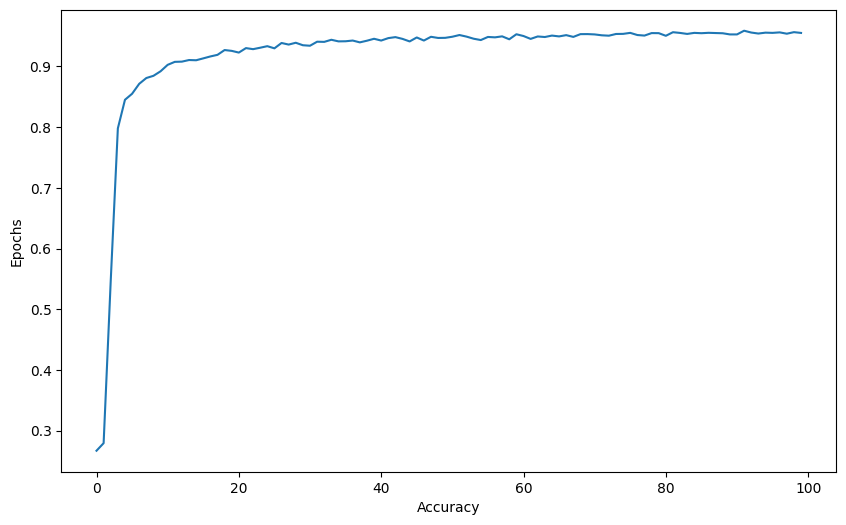

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(logs['val_categorical_accuracy'])
plt.xlabel('Accuracy')
plt.ylabel('Epochs')
plt.show()

In [ ]:
X_val,y_val = add_non_numbers(xmm_val, testy_new)

for i in range((X_val.shape[0])//2):
  add_lines(X_val[i])

X_val,y_val = shuffle(X_val,y_val)

In [ ]:
model.evaluate(X_val, y_val)

344/344 [==============================] - 1s 3ms/step - loss: 0.0064 - categorical_accuracy: 0.9572


[0.006443821359425783, 0.9571818113327026]

In [ ]:
prediction = model.predict(X_val)

344/344 [==============================] - 1s 2ms/step


In [ ]:
y_val

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

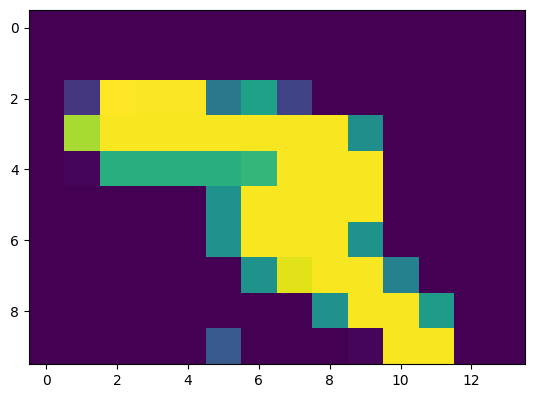

In [ ]:
plt.imshow(X_val[3][:10])

In [ ]:
X_val[3]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.15686275, 1.        , 0.99607843, 0.99607843,
        0.39607843, 0.57254902, 0.20392157, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.87058824, 0.99215686, 0.99215686, 0.99215686,
        0.99215686, 0.99215686, 0.99215686, 0.99215686, 0.49803922,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.01176471, 0.62745098, 0.62745098, 0.62745098,
        0.62745098, 0.6627451 , 0.99215686, 0.99215686, 0.99215686,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0. 

In [ ]:
y_val[3]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [ ]:
prediction[3]

array([1.5367465e-07, 1.8514406e-07, 4.0961336e-04, 8.1041412e-07,
       9.9999857e-01, 4.3933222e-05, 9.3637682e-06, 1.3104767e-06,
       2.0965834e-05, 2.1127235e-06, 1.9307672e-04], dtype=float32)

In [ ]:
y_pred = np.array([np.argmax(i) for i in prediction])

In [ ]:
y_true = np.array([np.argmax(i) for i in y_val])

In [ ]:
y_true

array([ 4,  4, 10, ...,  0,  2,  2])

In [ ]:
y_pred

array([ 4,  4, 10, ...,  0,  2,  2])

In [ ]:
np.sum((y_true == y_pred).astype(int))/y_true.shape[0]

0.9571818181818181

In [ ]:
cnf_mat = tf.math.confusion_matrix(labels = y_true, predictions = y_pred)
cnf_mat

<tf.Tensor: shape=(11, 11), dtype=int32, numpy=
array([[1000,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  966,    0,    1,    2,    1,    2,    2,    3,    1,    2],
       [   0,    2, 1121,    2,    1,    0,    1,    1,    3,    4,    0],
       [   0,    8,    2,  982,    5,    5,    1,    1,   15,   12,    1],
       [   0,    2,    3,    2,  974,    1,   10,    1,    4,   12,    1],
       [   0,    2,    5,    2,    1,  931,    5,    5,   10,    1,   20],
       [   0,    4,    0,    1,    9,    6,  838,    7,    4,   16,    7],
       [   0,    6,    4,    1,    1,    1,    7,  896,   14,    2,   26],
       [   0,    0,   10,    8,    4,    5,    1,    9,  961,    2,   28],
       [   0,    3,    0,   10,    9,    7,    5,    4,    2,  930,    4],
       [   0,    3,    4,    0,    3,   17,   15,   20,   14,    3,  930]],
      dtype=int32)>

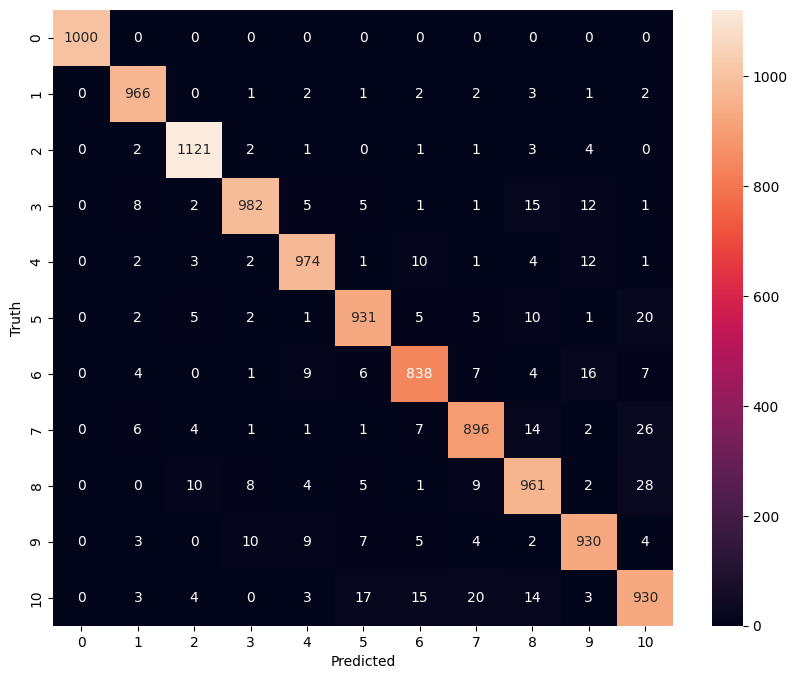

In [ ]:
plt.figure(figsize = (10,8))
sns.heatmap(cnf_mat, annot= True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [ ]:
y_true_pr = np.zeros(y_true.shape)
y_true_pr[y_true != 0] = 1

y_pred_pr = np.zeros(y_pred.shape)
y_pred_pr[y_pred != 0] = 1

In [ ]:
np.sum((y_true_pr == y_pred_pr).astype(int))/y_true_pr.shape[0]

1.0

In [ ]:
model.save('number_detection.keras')

In [ ]:
# Save the weights
model.save_weights('./checkpoints/Tata_Steel_Model')

In [ ]:
new_model = keras.Sequential([
    # keras.layers.MaxPooling2D((2,2),input_shape = (28,28,1)),
    # keras.layers.MaxPooling2D((2,2)),
    keras.layers.RandomRotation(0.5,input_shape = (14,14,1)),

    keras.layers.Conv2D(filters = 16, padding = 'same', kernel_size = (3,3), activation = 'relu'),

    # keras.layers.Conv2D(filters = 32, padding = 'same', kernel_size = (3,3), activation = 'relu'),
    # keras.layers.Conv2D(filters = 64, padding = 'same', kernel_size = (3,3), activation = 'relu'),
    # keras.layers.MaxPooling2D((2,2)),
    # keras.layers.Conv2D(filters = 128, padding = 'same', kernel_size = (3,3), activation = 'relu'),
    keras.layers.Conv2D(filters = 256, padding = 'same', kernel_size = (3,3), activation = 'relu'),

    keras.layers.Flatten(),
    keras.layers.Dense(1000, activation = 'relu'),
    # keras.layers.Dense(11, activation = 'relu'),
    # keras.layers.Dropout(0.05),
    keras.layers.Dense(11, activation = 'sigmoid')
])

new_model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = [keras.metrics.CategoricalAccuracy()])

new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_1 (RandomR  (None, 14, 14, 1)         0         
 otation)                                                        
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 256)       37120     
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 dense_2 (Dense)             (None, 1000)              50177000  
                                                                 
 dense_3 (Dense)             (None, 11)                11011     
                                                      

In [ ]:
# Restore the weights
new_model.load_weights('./checkpoints/Tata_Steel_Model')

In [ ]:
new_model.evaluate(X_val, y_val)

344/344 [==============================] - 1s 3ms/step - loss: 0.0064 - categorical_accuracy: 0.9572


[0.006443821359425783, 0.9571818113327026]

## Large Network

In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(filters = 16, padding = 'same', kernel_size = (3,3), activation = 'relu', input_shape = (28,28,1)),
    keras.layers.MaxPooling2D((2,2)),

    keras.layers.Conv2D(filters = 64, padding = 'same', kernel_size = (3,3), activation = 'relu'),
    keras.layers.MaxPooling2D((2,2)),

    keras.layers.Flatten(),
    keras.layers.Dense(3136, activation = 'relu'),
    keras.layers.Dense(196, activation = 'relu'),
    keras.layers.Dense(10, activation = 'softmax')
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

model.summary()

In [ ]:
checkpoint_path = "training_1/val_loss.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

csv_logger = CSVLogger('training_log2.csv', append=True)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor = 'val_loss',
                                                 verbose=1)

# Train the model with the new callback
model.fit(trainxmm,
          trainy,
          epochs=100,
          batch_size = 1000,
          validation_data=(testxmm, testy),
          callbacks=[csv_logger])

In [ ]:
logs2 = pd.read_csv('training_log2.csv')

In [ ]:
logs2['val_accuracy'].max()

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(logs['val_accuracy'], color='blue')
plt.plot(logs2['val_accuracy'], color='orange')
plt.xlabel('Accuracy')
plt.ylabel('Epochs')
plt.show()

In [ ]:
model.evaluate(testxmm, testy)